(https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Cassandra1.jpeg/800px-Cassandra1.jpeg)
## Notebook to run serial methods

With this notebook you can run live/backtest Kaissandra, plot live results and much more

In [1]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")
    
import pandas as pd
import datetime as dt
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ added to python path


## Init Util Functions and Constants 

In [2]:
def get_positions_filename(asset, open_dt, close_dt):
    """  """
    
    dt_open = dt.datetime.strftime(dt.datetime.strptime(
            open_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    dt_close = dt.datetime.strftime(dt.datetime.strptime(
            close_dt,'%Y.%m.%d %H:%M:%S'),'%y%m%d%H%M%S')
    filename = 'O'+dt_open+'C'+dt_close+asset
    return filename

In [3]:
live = True

if live:
    ext = '_LI_'
    directory = 'kaissandra_live/live'
    start_time = '19_01_27_23_18_41'
else:
    ext = '_BT_'
    directory = 'back_test'
    start_time = '19_01_27_16_04_55'
results_dir = '../../RNN/resultsLive/'+directory+'/trader/'
positions_dir = '../../RNN/resultsLive/'+directory+'/positions/'+start_time+'/'
filename = results_dir+start_time+ext+"positions_soll.log"
positions = pd.read_csv(filename).sort_values(by=['Entry Time']).reset_index().drop(labels='index',axis=1)
print(positions.to_string())

    Asset           Entry Time            Exit Time  Position         Bi         Ai         Bo         Ao  ticks_d      GROI    Spread       ROI     Profit  E_spread  stoploss    stGROI     stROI
0  EURUSD  2019.01.29 02:23:21  2019.01.29 02:50:01         1    1.14272    1.14279    1.14282    1.14289        0  0.008751  0.006125  0.002625   0.262515  0.006127         2  0.008751  0.002625
1  GBPUSD  2019.01.29 15:44:10  2019.01.29 15:47:41         2    1.31906    1.31917    1.31771    1.31781        0 -0.103095  0.007581 -0.110676 -11.067565  0.008339         2 -0.103095 -0.110676
2  EURGBP  2019.01.29 19:56:32  2019.01.29 20:03:09         2    0.86936    0.86946    0.86974    0.86988        0  0.048306  0.016102  0.032204   3.220390  0.011501         2  0.048306  0.032204
3  EURGBP  2019.01.29 21:55:50  2019.01.29 22:01:04        -2    0.87214    0.87229    0.87251    0.87266        0 -0.042399  0.017189 -0.059588  -5.958793  0.016041         2  0.005907 -0.027384
4  EURGBP  2019.01.2

## Build Stats File and Plot Positions

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


    asset          Di        Ti          Do        To  direction      groi       roi     profit  e_spread    spread       max       min  argmax  argmin  samples  extensions  stoploss                              file
0  EURUSD  2019.01.29  02:23:21  2019.01.29  02:50:01          1  0.008751  0.002625   0.262515  0.006127  0.006125  0.024501 -0.026252      97      26      123           7         2  O190129022321C190129025001EURUSD
1  GBPUSD  2019.01.29  15:44:10  2019.01.29  15:47:41          2 -0.103095 -0.110676 -11.067565  0.008339  0.007581  0.029564 -0.119014       3      85      101           0         2  O190129154410C190129154741GBPUSD
2  EURGBP  2019.01.29  19:56:32  2019.01.29  20:03:09          2  0.048306  0.032204   3.220390  0.011501  0.016102  0.079360 -0.011501      49      10      101           0         2  O190129195632C190129200309EURGBP
3  EURGBP  2019.01.29  21:55:50  2019.01.29  22:01:04         -2 -0.042399 -0.059588  -5.958793  0.016041  0.017189  0.074429 -0.123

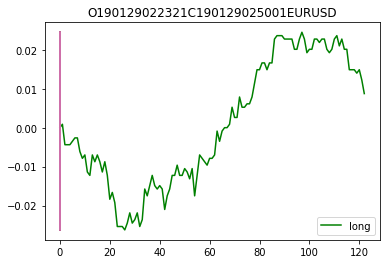

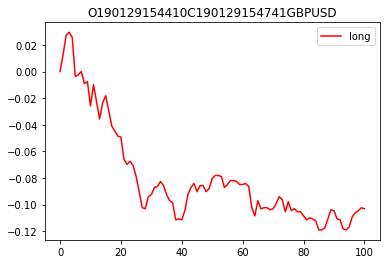

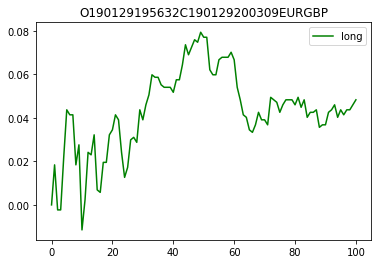

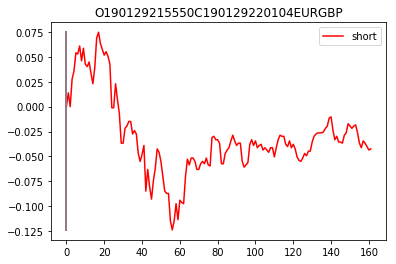

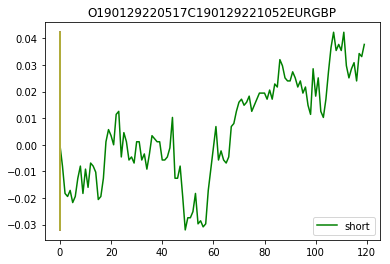

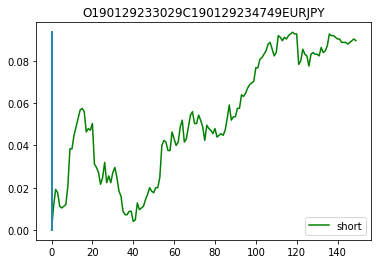

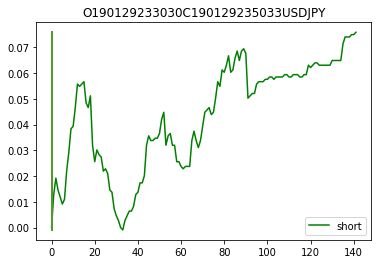

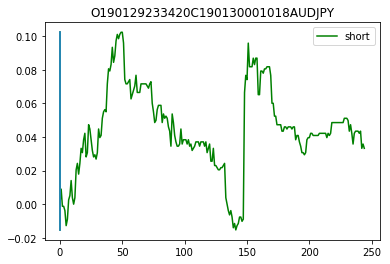

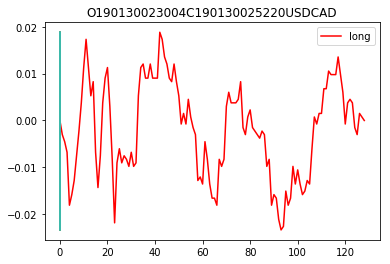

In [4]:
columns = ['asset','Di','Ti','Do','To','direction','groi','roi','profit','e_spread','spread','max','min','argmax','argmin','samples','extensions','stoploss','file']
pos_format = pd.DataFrame(data=0,columns=columns,index=range(positions.shape[0]))
plt_index = 0
for p in range(positions.shape[0]):
    #print(positions.iloc[p])
    pos_format['asset'].iloc[p] = positions['Asset'].iloc[p]
    pos_format['Di'].iloc[p] = positions['Entry Time'].iloc[p][:10]
    pos_format['Ti'].iloc[p] = positions['Entry Time'].iloc[p][11:]
    pos_format['Do'].iloc[p] = positions['Exit Time'].iloc[p][:10]
    pos_format['To'].iloc[p] = positions['Exit Time'].iloc[p][11:]
    pos_format['groi'].iloc[p] = positions['GROI'].iloc[p]
    pos_format['roi'].iloc[p] = positions['ROI'].iloc[p]
    pos_format['e_spread'].iloc[p] = positions['E_spread'].iloc[p]
    pos_format['spread'].iloc[p] = positions['Spread'].iloc[p]
    pos_format['profit'].iloc[p] = positions['Profit'].iloc[p]
    pos_format['stoploss'].iloc[p] = positions['stoploss'].iloc[p]
    direction = positions['Position'].iloc[p]
    pos_format['direction'].iloc[p] = direction
    filename_pos = get_positions_filename(positions['Asset'].iloc[p], positions['Entry Time'].iloc[p], positions['Exit Time'].iloc[p])
    pos_format['file'].iloc[p] = filename_pos
    pos_ev = pd.read_csv(positions_dir+filename_pos+'.txt', sep=',')
    pos_track = pickle.load( open( positions_dir+filename_pos+".p", "rb" ))
    #print(pos_track)
    pos_format['extensions'].iloc[p] = pos_track['n_ext']
    pos_format['samples'].iloc[p] = pos_ev.shape[0]
    #print(pos_ev.columns)
    maxBid = pos_ev['SymbolBid'].max()
    minBid = pos_ev['SymbolBid'].min()
    maxAsk = pos_ev['SymbolAsk'].max()
    minAsk = pos_ev['SymbolAsk'].min()
    Bi = positions['Bi'].iloc[p]
    Ai = positions['Ai'].iloc[p]
    #if direction>0:
    #        GROI_live = roi_ratio*(Ao-Ai)/Ai
    #        spread = (Ao-Bo)/Ai
    #        
    #    else:
    #        GROI_live = roi_ratio*(Bi-Bo)/Ao
    if direction>0:
        pos_format['max'].iloc[p] = 100*(maxAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['min'].iloc[p] = 100*(minAsk-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        pos_format['argmax'].iloc[p] = pos_ev['SymbolAsk'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolAsk'].idxmin()
        groi_ev = 100*(pos_ev['SymbolAsk'].iloc[:]-positions['Ai'].iloc[p])/positions['Ai'].iloc[p]
        label = 'long'
    else:
        pos_format['max'].iloc[p] = 100*(positions['Bi'].iloc[p]-minBid)/maxAsk
        pos_format['min'].iloc[p] = 100*(positions['Bi'].iloc[p]-maxBid)/maxAsk
        pos_format['argmax'].iloc[p] = pos_ev['SymbolBid'].idxmax()
        pos_format['argmin'].iloc[p] = pos_ev['SymbolBid'].idxmin()
        groi_ev = 100*(positions['Bi'].iloc[p]-pos_ev['SymbolBid'].iloc[:])/pos_ev['SymbolAsk'].iloc[:]
        label = 'short'
    if positions['GROI'].iloc[p]>0:
        color = 'green'
    else:
        color = 'red'
    plt.figure(plt_index)
    plt.plot(groi_ev, color=color, label=label)
    for e in range(pos_track['n_ext']):
        plt.plot([pos_track['@tick#'][e+1] for i in range(2)],[pos_format['min'].iloc[p], pos_format['max'].iloc[p]])
    plt.legend()
    plt.title(filename_pos)
    plt_index += 1
print(pos_format.to_string())
pos_format.to_csv(positions_dir+'stats.csv', index=False, sep='\t', float_format='%.5f')
print("Positions summary saved")

## Get Summary from Position Stats

In [5]:
tgroi = pos_format['groi'].sum()
troi = pos_format['roi'].sum()
tprofit = pos_format['profit'].sum()
mspread = pos_format['spread'].mean()
emspread = pos_format['e_spread'].mean()
SIs = pos_format.agg({'groi': lambda x: 100*np.sum(x>0)/len(x),
                      'roi': lambda x: 100*np.sum(x>0)/len(x)})
av_win = sum(pos_format[pos_format['groi']>0]['groi'])/len(pos_format[pos_format['groi']>0]['groi'])
av_lose = sum(pos_format[pos_format['groi']<0]['groi'])/len(pos_format[pos_format['groi']<0]['groi'])
per_under_2p = 100*pos_format[pos_format['e_spread']<0.02].shape[0]/pos_format.shape[0]

print("Total GROI = {0:.2f}% ".format(tgroi)+"Total ROI = {0:.2f}% ".format(troi)+"total profit = {0:.2f}e ".format(tprofit)+"mean spread = {0:.2f} pips ".format(100*mspread)+
      "expected mean spread = {0:.2f} pips ".format(100*emspread))
print("Number entries "+str(pos_format.shape[0])+" GSP = {0:.2f}% ".format(SIs['groi'])+" NSP = {0:.2f}% ".format(SIs['roi'])+" av win = {0:.3f}% ".format(av_win)+" av lose = {0:.3f}% ".format(av_lose))
print("Percent below 2p {0:.2f}%".format(per_under_2p))
#print(pd.DataFrame(prob_rois))
grouped = pos_format.groupby(['asset'])
#print(grouped.get_group(('GBPJPY',1)).to_string())
#grouped.aggregate(np.sum)
#grouped['groi'].describe()
#grouped.get_group('GBPJPY')
SI = grouped.agg({'groi': lambda x: np.sum(x>0)/len(x),
             'roi': lambda x: np.sum(x>0)/len(x)})#.rename(['GSI','NSI'])
grouped.agg({'e_spread': lambda x: 100*np.sum(x<0.02)/len(x)})
#print(SI)
#print(grouped.describe())
#for name, group in grouped:
    #print(name)
#    print(group.to_string())

Total GROI = 0.15% Total ROI = -0.01% total profit = -0.55e mean spread = 1.71 pips expected mean spread = 1.43 pips 
Number entries 9 GSP = 66.67%  NSP = 55.56%  av win = 0.049%  av lose = -0.073% 
Percent below 2p 88.89%


,e_spread
asset,
AUDJPY,0.0
EURGBP,100.0
EURJPY,100.0
EURUSD,100.0
GBPUSD,100.0
USDCAD,100.0
USDJPY,100.0


## Run KaissandOnline

In [ ]:
def group_by_positive_groi(df):
    if 

In [ ]:
# runLive in multiple processes
from multiprocessing import Process
from runLive import run
import datetime as dt
import time

assets = [1, 2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 16, 17, 19, 27, 28, 29, 30, 31, 32]#
running_assets = assets#[7, 14]
start_time = dt.datetime.strftime(dt.datetime.now(),'%y_%m_%d_%H_%M_%S')
#disp = Process(target=run, args=[running_assets,start_time])
#disp.start()
for ass_idx in range(len(running_assets)):
    disp = Process(target=run, args=[running_assets[ass_idx:ass_idx+1],start_time])
    disp.start()
    time.sleep(2)

## Get total returns

In [ ]:
import pandas as pd
start_time = '18_12_10_10_53_20'
results_dir = '../RNN/resultsLive/back_test/trader/'
filename = results_dir+start_time+'_LI_'+"positions_soll.log"
positions = pd.read_csv(filename)
print(positions.GROI.sum())
print(positions.ROI.sum())
print(positions.Profit.sum())
print(positions.Profit)